<a href="https://colab.research.google.com/github/Immaczx/SemanticSegmentation/blob/master/Notebooks/UnetTLMobilenetV2SegmentationZeaMaysSeeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.image_segmentation.git --quiet

  Preparing metadata (setup.py) ... done


In [ ]:
!git clone https://github.com/Immaczx/SemanticSegmentation.git

Cloning into 'SemanticSegmentation'...
remote: Enumerating objects: 184, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 184 (delta 84), reused 144 (delta 44), pack-reused 0
Receiving objects: 100% (184/184), 42.48 KiB | 3.54 MiB/s, done.
Resolving deltas: 100% (84/84), done.


In [ ]:
from SemanticSegmentation import utils
import os
import math as m
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from gcpds.image_segmentation.datasets.segmentation import ZeaMaysSeeds
from gcpds.image_segmentation.losses import DiceCoefficient
from gcpds.image_segmentation.metrics import Jaccard, Sensitivity, Specificity
from gcpds.image_segmentation.metrics import DiceCoefficientMetric
from gcpds.image_segmentation.models import unet_baseline, fcn_baseline, segnet_baseline, res_unet_baseline

In [ ]:
import tensorflow as tf 
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def upsample(filters,size,strides=2,padding="same",batchnorm=False,dropout=0):

    layer = tf.keras.Sequential()
    layer.add(
        tf.keras.layers.Conv2DTranspose(filters,size,strides,padding,use_bias = False))

    if batchnorm:
        layer.add(tf.keras.layers.BatchNormalization())

    if dropout != 0:
        layer.add(tf.keras.layers.Dropout(dropout))

    layer.add(tf.keras.layers.ReLU())

    return layer
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def get_encoder(input_shape=[None,None,3], trainable = True, name="encoder"): 
    Input = tf.keras.layers.Input(shape=input_shape)
    base_model = tf.keras.applications.MobileNetV2(input_tensor=Input, include_top=False)
    layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
    ]
    layers = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    encoder  = tf.keras.Model(inputs=Input, outputs=layers,name=name)
    encoder.trainable = trainable

    return encoder 
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def get_decoder(skips,dropout=0):
    up_stack = [
        upsample(512, 3, batchnorm=True, dropout=dropout),  # 4x4 -> 8x8
        upsample(256, 3, batchnorm=True, dropout=dropout),  # 8x8 -> 16x16
        upsample(128, 3, batchnorm=True, dropout=dropout),  # 16x16 -> 32x32
        upsample(64, 3, batchnorm=True, dropout=dropout),   # 32x32 -> 64x64
    ]
    x = skips[-1]
    skips = reversed(skips[:-1])
1
    for up,skip in zip(up_stack,skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x,skip])
    return x
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def unet_mobilenet(input_shape=(128,128,3), out_channels=1, out_ActFunction='sigmoid', trainable = False, name="unetMobile"):
    input = tf.keras.layers.Input(shape=input_shape)

    skips = get_encoder(input_shape=list(input.shape[1:]),  trainable = trainable)(input)

    x = get_decoder(skips, dropout=0.25)

    last = tf.keras.layers.Conv2DTranspose(
        out_channels, kernel_size=(3,3), strides=2,
        padding='same',activation=out_ActFunction)  #64x64 -> 128x128

    x = last(x)
    model = tf.keras.Model(inputs=input, outputs=x,name=name)
    return model

9406464/9406464 [==============================] - 0s 0us/step


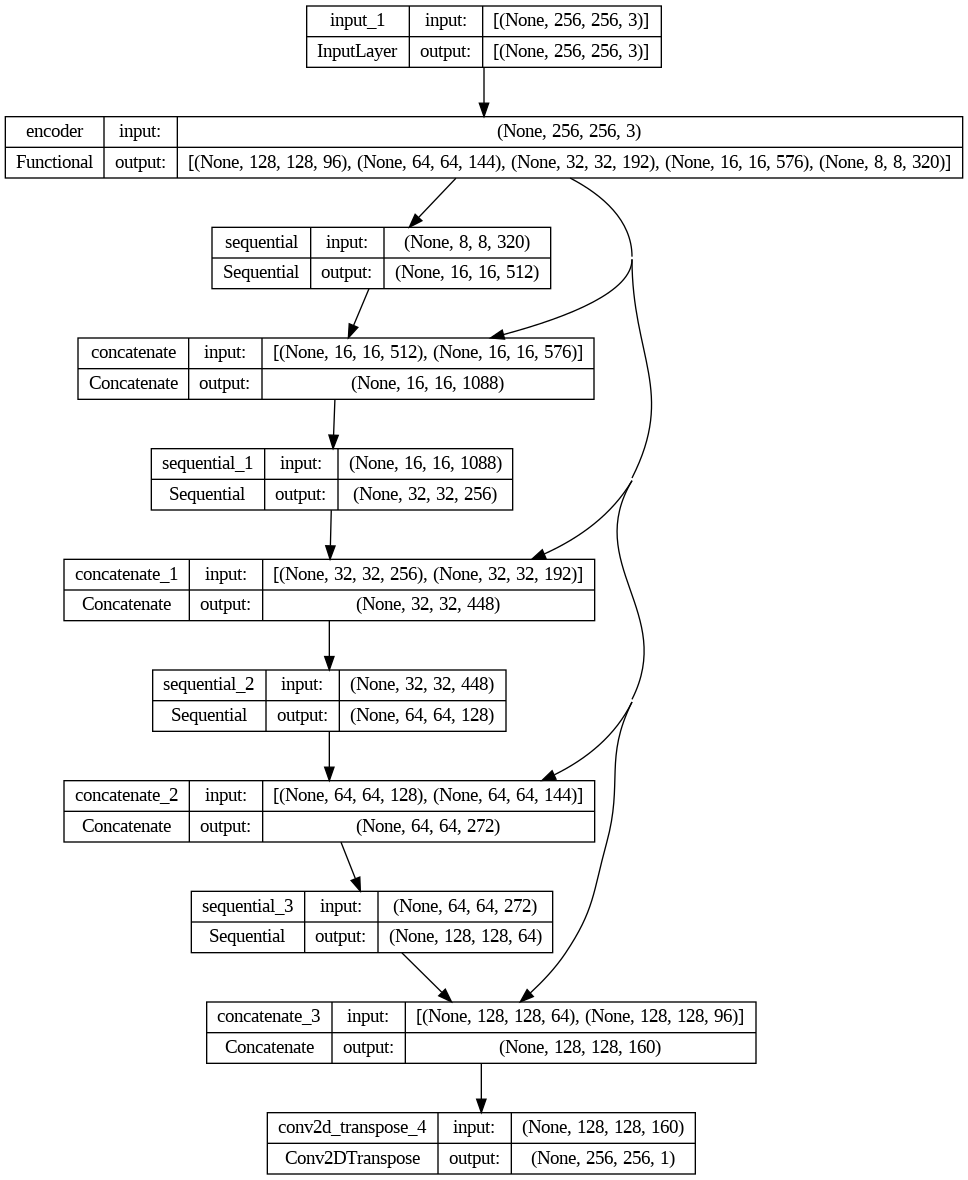

In [ ]:
image_size=256
out_channels = 1

model = unet_mobilenet(input_shape=(image_size,image_size,3), out_channels=out_channels, trainable=False)
model.compile(loss=DiceCoefficient(), optimizer='Adam', metrics=[DiceCoefficientMetric(), Jaccard(), Sensitivity(), Specificity()])
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
tf.keras.utils.plot_model(model, show_shapes=True)


Downloading...
From: https://drive.google.com/uc?id=14cI9XDnl6TS6uWSpnC-ifoGy3iLe4u0l&confirm=t
To: /usr/local/lib/python3.10/dist-packages/gcpds/image_segmentation/datasets/segmentation/Datasets/ZeaMaysSeeds/ZeaMaysSeeds.zip
100%|██████████| 122M/122M [00:02<00:00, 49.9MB/s]


 Number of images for Partition 1: 2016
 Number of images for Partition 2: 864
 Number of images for Partition 3: 320
10/10 [==============================] - 1s 104ms/step - loss: -0.9866 - DiceCoefficientMetric: -0.9866 - Jaccard: 0.9737 - Sensitivity: 0.9856 - Specificity: 0.9992


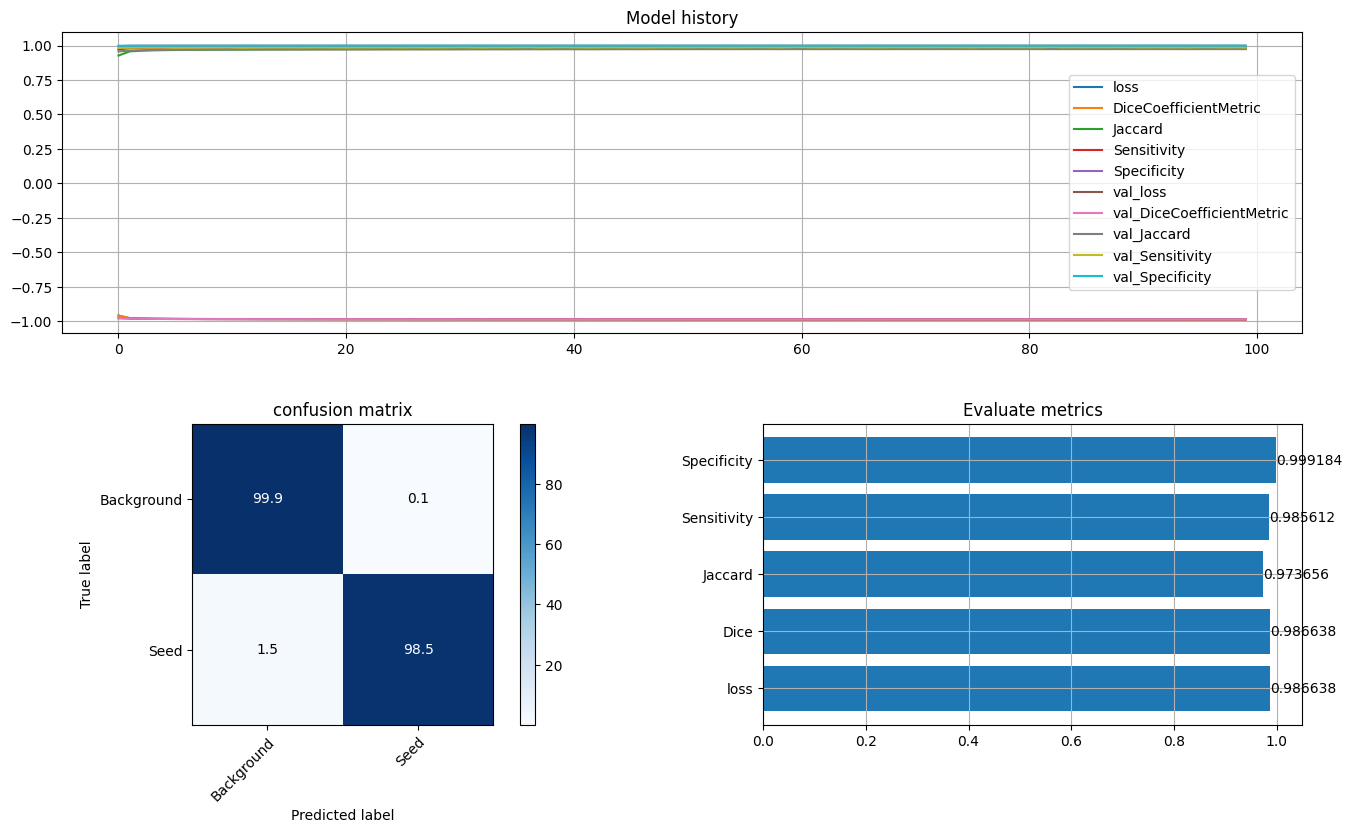

 Number of images for Partition 1: 2016
 Number of images for Partition 2: 864
 Number of images for Partition 3: 320


In [ ]:
for i in range(5):
  num = np.random.randint(0, 100)
  dataset = ZeaMaysSeeds(split=[0.1,0.3], seed = num)
  train,val,test = dataset()

  def preprocess(img,mask):
      img = tf.image.resize(img,(256,256))
      mask = tf.image.resize(mask,(256,256))#Ch 1: Seed, Ch 2: No germinate, Ch 3: germinate
      mask = tf.cast(mask>0, tf.float32)
      mask = mask[...,2][..., None]
      return img,mask

  train = train.map(lambda x,y,id:preprocess(x,y))
  train = train.batch(1)
  val = val.map(lambda x,y,id:preprocess(x,y))
  val = val.batch(1)
  test = test.map(lambda x,y,id:preprocess(x,y))
  test = test.batch(1)

  train = train.cache()
  val = val.cache()
  test = test.cache()
  #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  model_history = model.fit(train,validation_data=val, epochs=100, verbose=0)
  #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  fig = plt.figure(figsize=(16,9))

  gs = fig.add_gridspec(2, 2)
  ax1 = fig.add_subplot(gs[0, :])
  ax2 = fig.add_subplot(gs[1, :-1])
  ax3 = fig.add_subplot(gs[1:, -1])

  for i in model_history.history:
    ax1.plot(model_history.history[i],label=i)
  ax1.set_title('Model history')
  ax1.legend()
  ax1.grid()
  #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  img_test = tf.zeros((0, 256, 256, 3), dtype=tf.float32)
  mask_test = tf.zeros((0, 256, 256,1), dtype=tf.float32)

  for img, mask in test:
      img_test = tf.concat([img_test, img], axis=0)
      mask_test = tf.concat([mask_test, mask], axis=0)
  #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  mask_pred = model.predict(img_test)
  mask_pred = np.where(mask_pred > .5, 1, 0)
  evaluate_history = model.evaluate(img_test, mask_test)
  bars = ax3.barh(["loss","Dice","Jaccard","Sensitivity","Specificity"],np.abs(evaluate_history))
  ax3.bar_label(bars)
  ax3.set_title('Evaluate metrics')
  ax3.grid()

  #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  # Then, convert the predicted and ground truth masks to single-dimensional arrays
  pred_flat = tf.reshape(mask_pred, [-1])
  true_flat = tf.reshape(mask_test, [-1])

  # Plot the confusion matrix
  utils.plot_confusion_matrix(true_flat, pred_flat, classes=['Background','Seed'], ax = ax2)
  ax2.set_title('confusion matrix')

  # Ajustar los espacios entre los subplots
  fig.subplots_adjust(wspace=0.3, hspace=0.3)

  # Mostrar la figura
  plt.show()
  #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  del train, val, test, dataset
  tf.keras.backend.clear_session()
  #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------